In [56]:
# 🛠️ Prioritize local 'src' directory for imports
import sys, os
sys.path.insert(0, os.path.abspath("../src"))

# 📦 Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# 📥 Custom Modules
from preprocessing import load_and_prepare_data, split_and_scale, select_top_features
from resampling import (
    manual_upsampling, smote, adasyn, borderline_smote,
    smote_tomek, smote_enn, random_undersample, cluster_centroids
)
from model_eval import evaluate_model
from models import make_model

In [58]:
# 📄 Load + prepare dataset
data_path = "../data/synth_rare_event_data.csv"
target_col = "rare_event"

X, y = load_and_prepare_data(data_path, target_col)
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(X, y)
X_train, X_test, _ = select_top_features(X_train_scaled, y_train, X_test_scaled, return_features=True)

In [60]:
# 📊 Define resampling strategies
resampled_datasets = {
    "Manual Upsampling": manual_upsampling(X_train, y_train, target_col),
    "SMOTE": smote(X_train, y_train),
    "ADASYN": adasyn(X_train, y_train),
    "Borderline SMOTE": borderline_smote(X_train, y_train),
    "SMOTETomek": smote_tomek(X_train, y_train),
    "SMOTEENN": smote_enn(X_train, y_train),
    "Random Undersample": random_undersample(X_train, y_train),
    "Cluster Centroids": cluster_centroids(X_train, y_train),
    "No Resampling": (X_train, y_train)
}

In [61]:
# 🧬 Evolution Utilities
def mutate_params(base_params, noise=0.1):
    return {
        "C": max(0.01, base_params["C"] + np.random.uniform(-noise, noise)),
        "l1_ratio": min(1.0, max(0.0, base_params["l1_ratio"] + np.random.uniform(-noise, noise)))
    }

def make_child_model(params):
    return LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=params["l1_ratio"],
        C=params["C"],
        max_iter=5000,
        tol=1e-4,
        class_weight='balanced',
        random_state=42
    )

def breed_and_battle(resampled_datasets, X_test, y_test, generations=3, top_k=3):
    population = []

    # Initial population
    for label, (X_res, y_res) in resampled_datasets.items():
        base_params = {"C": 1.0, "l1_ratio": 0.5}
        model = make_child_model(base_params)
        model.fit(X_res, y_res)
        score = evaluate_model(model, X_test, y_test, label=label, return_scores=True)

        population.append({
            "model": model,
            "params": base_params,
            "score": score,
            "label": label,
            "generation": 0
        })

    for gen in range(1, generations + 1):
        print(f"\nGeneration {gen}")

        # Select top_k by PR AUC
        population = sorted(population, key=lambda x: x["score"]["pr_auc"], reverse=True)[:top_k]
        new_population = []

        for parent in population:
            for _ in range(2):  # 2 children per parent
                child_params = mutate_params(parent["params"])
                child_model = make_child_model(child_params)
                X_res, y_res = resampled_datasets[parent["label"]]
                child_model.fit(X_res, y_res)
                score = evaluate_model(child_model, X_test, y_test, label=f"{parent['label']} Gen{gen}", return_scores=True)

                new_population.append({
                    "model": child_model,
                    "params": child_params,
                    "score": score,
                    "label": parent["label"],
                    "generation": gen
                })

        population.extend(new_population)

    return population


--- Manual Upsampling ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


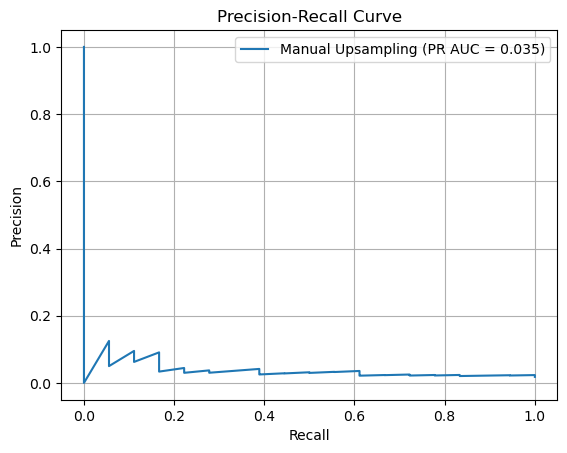

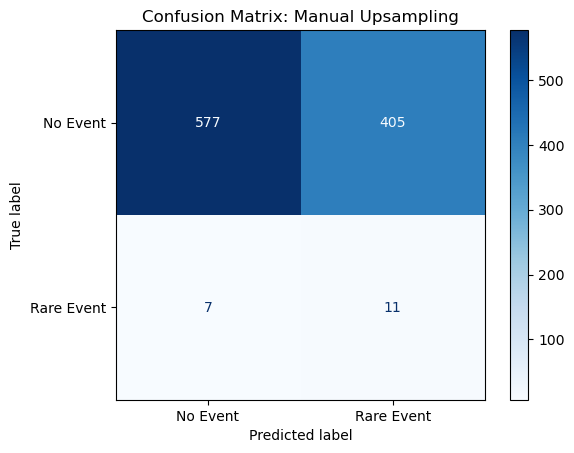


--- SMOTE ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.632
PR AUC: 0.029


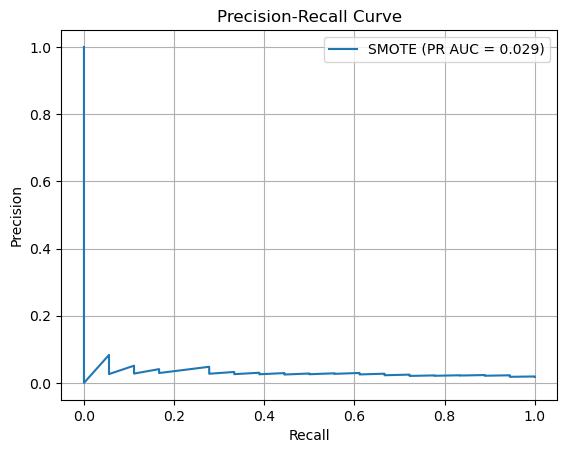

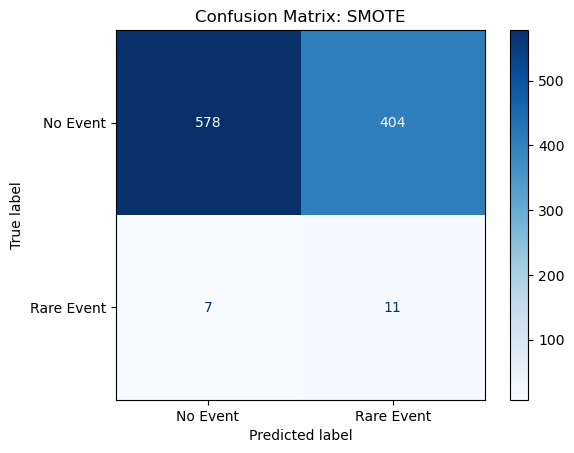


--- ADASYN ---
              precision    recall  f1-score   support

           0       0.98      0.58      0.73       982
           1       0.02      0.50      0.04        18

    accuracy                           0.58      1000
   macro avg       0.50      0.54      0.39      1000
weighted avg       0.97      0.58      0.72      1000

ROC AUC: 0.617
PR AUC: 0.03


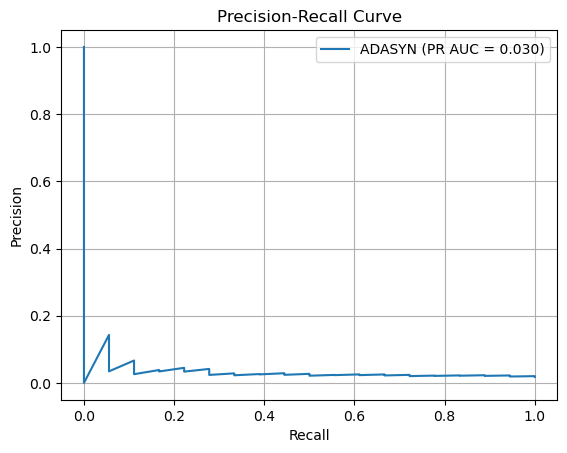

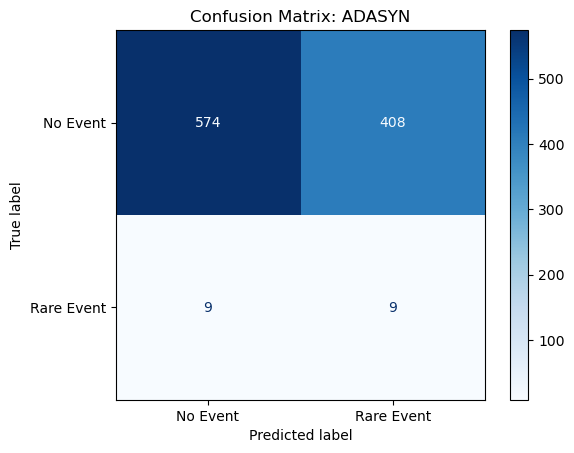


--- Borderline SMOTE ---
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       982
           1       0.02      0.44      0.05        18

    accuracy                           0.67      1000
   macro avg       0.50      0.56      0.42      1000
weighted avg       0.97      0.67      0.79      1000

ROC AUC: 0.579
PR AUC: 0.026


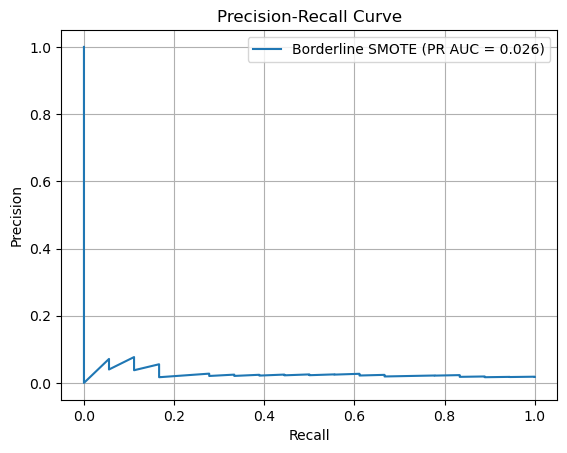

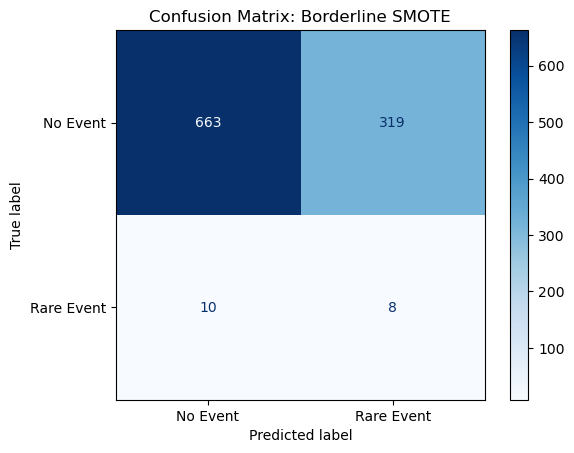


--- SMOTETomek ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.632
PR AUC: 0.029


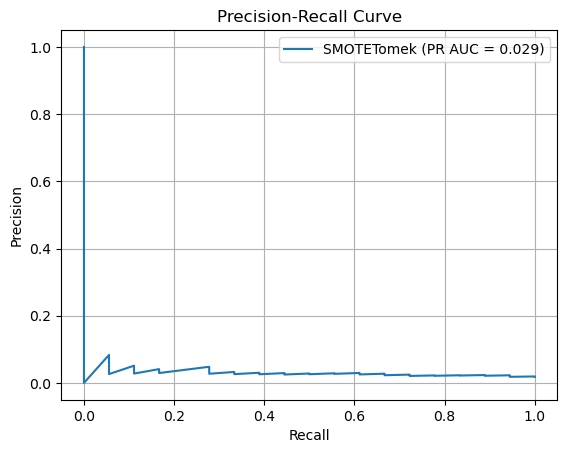

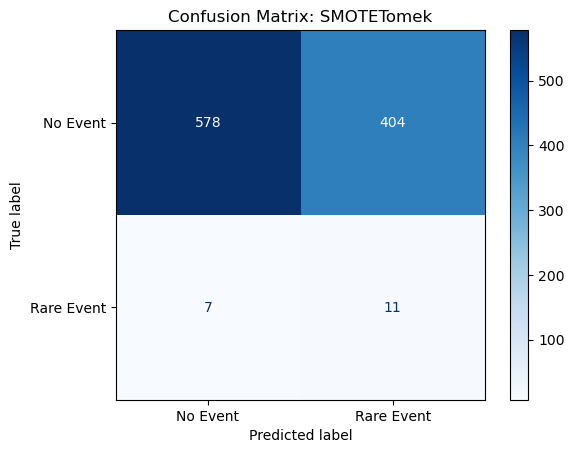


--- SMOTEENN ---
              precision    recall  f1-score   support

           0       0.99      0.57      0.73       982
           1       0.03      0.67      0.05        18

    accuracy                           0.57      1000
   macro avg       0.51      0.62      0.39      1000
weighted avg       0.97      0.57      0.71      1000

ROC AUC: 0.619
PR AUC: 0.027


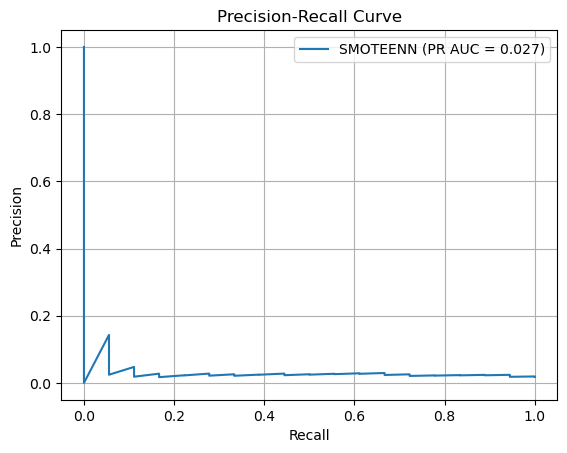

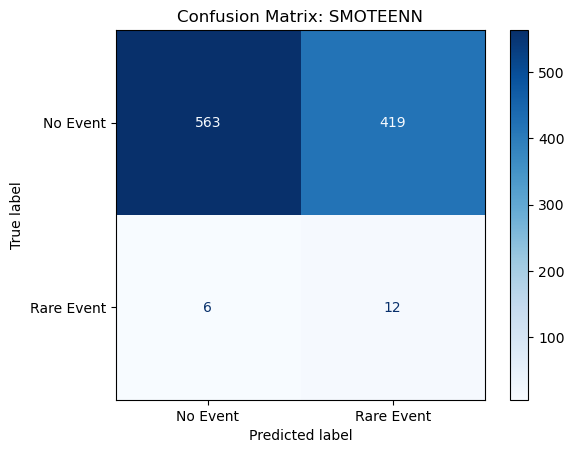


--- Random Undersample ---
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       982
           1       0.02      0.56      0.04        18

    accuracy                           0.54      1000
   macro avg       0.50      0.55      0.37      1000
weighted avg       0.97      0.54      0.68      1000

ROC AUC: 0.606
PR AUC: 0.032


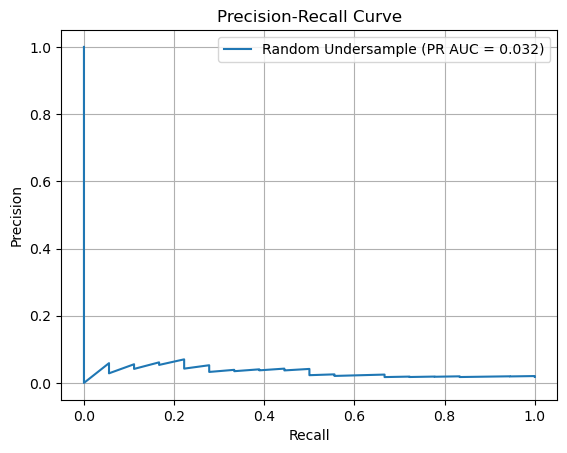

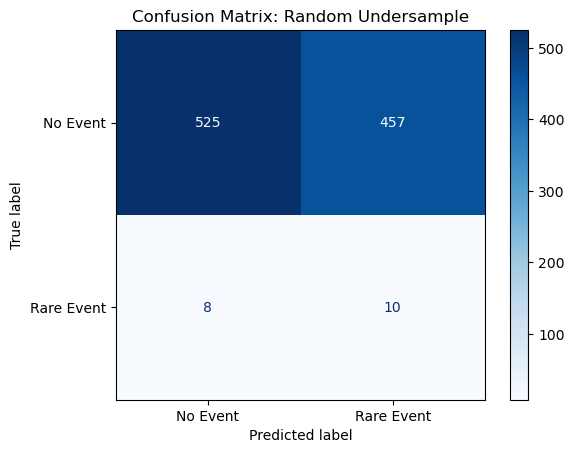


--- Cluster Centroids ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.043


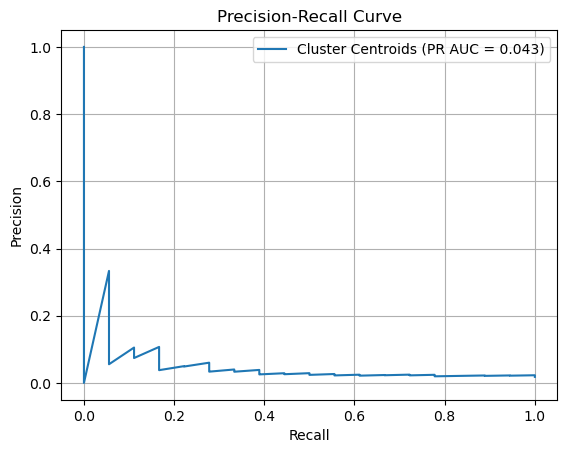

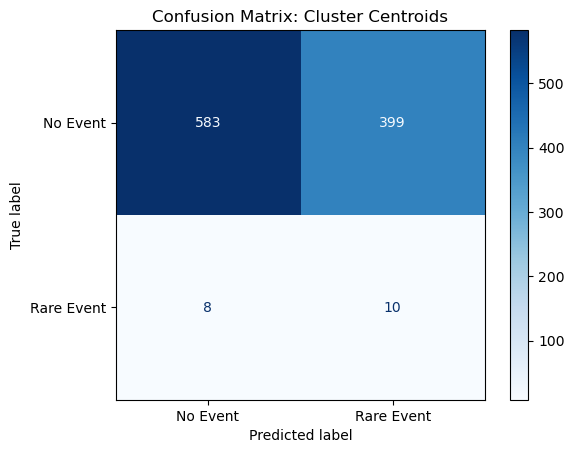


--- No Resampling ---
              precision    recall  f1-score   support

           0       0.98      0.47      0.64       982
           1       0.02      0.56      0.04        18

    accuracy                           0.47      1000
   macro avg       0.50      0.51      0.34      1000
weighted avg       0.97      0.47      0.63      1000

ROC AUC: 0.479
PR AUC: 0.016


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


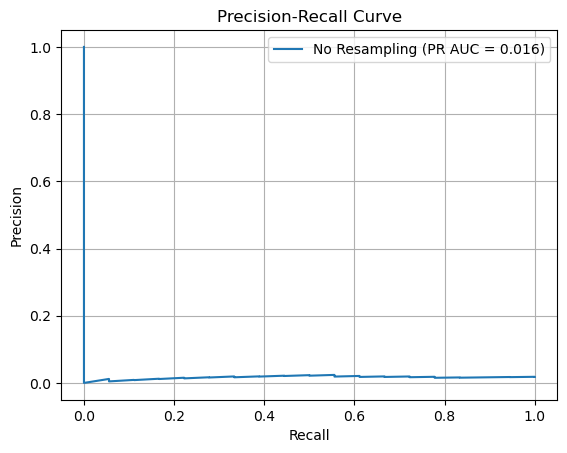

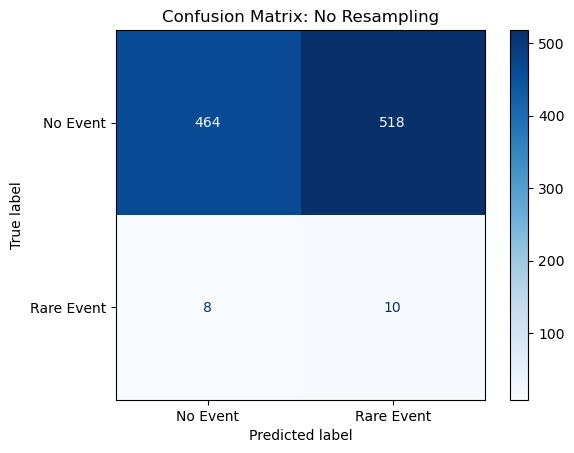


Generation 1

--- Cluster Centroids Gen1 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.043


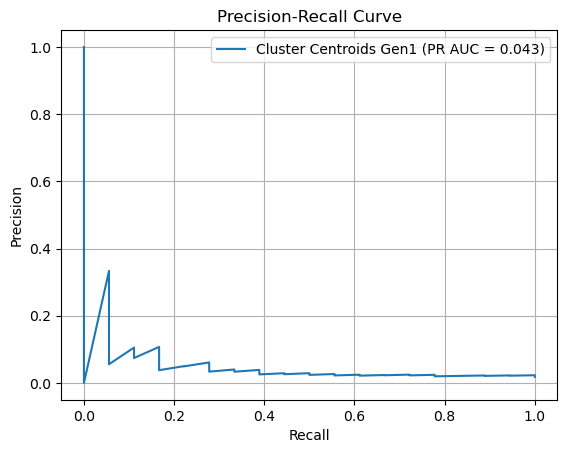

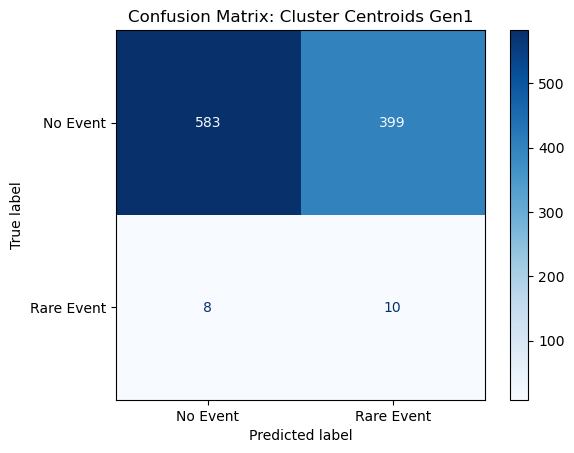


--- Cluster Centroids Gen1 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


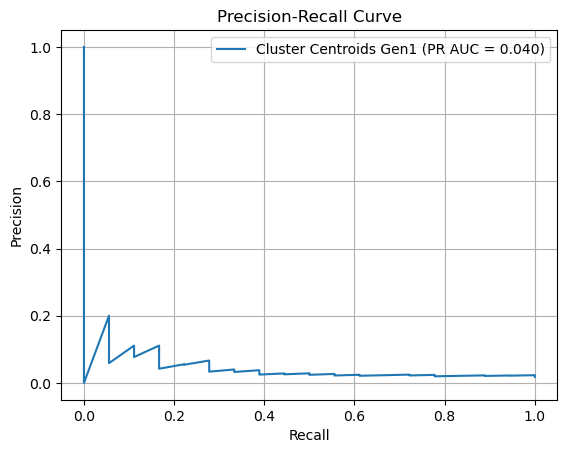

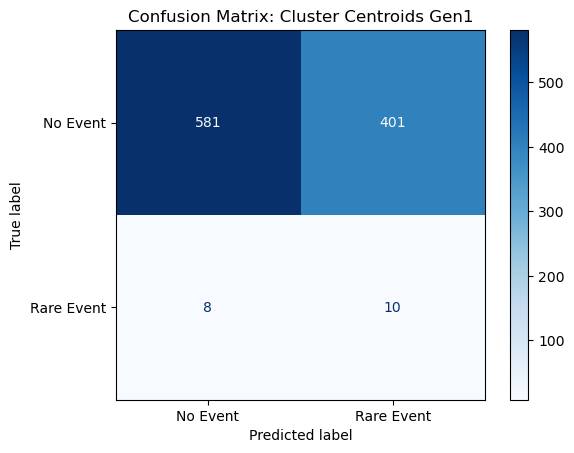


--- Manual Upsampling Gen1 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


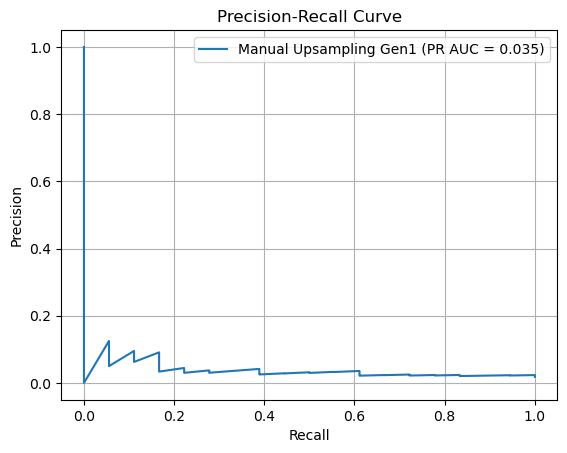

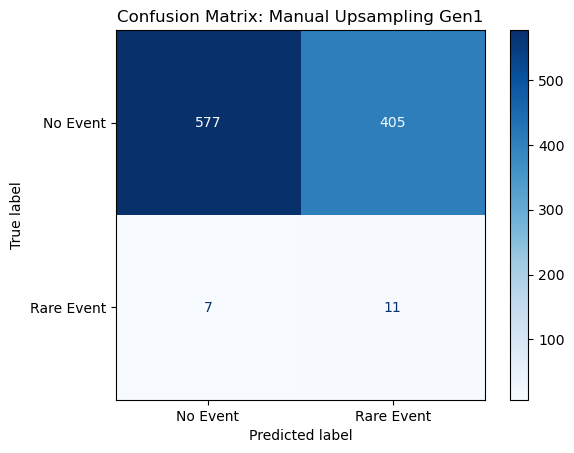


--- Manual Upsampling Gen1 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


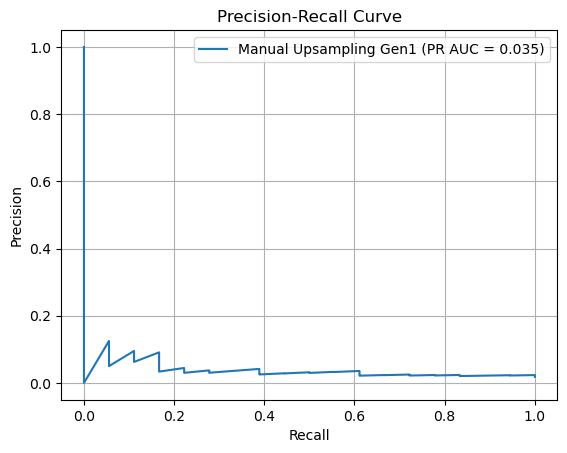

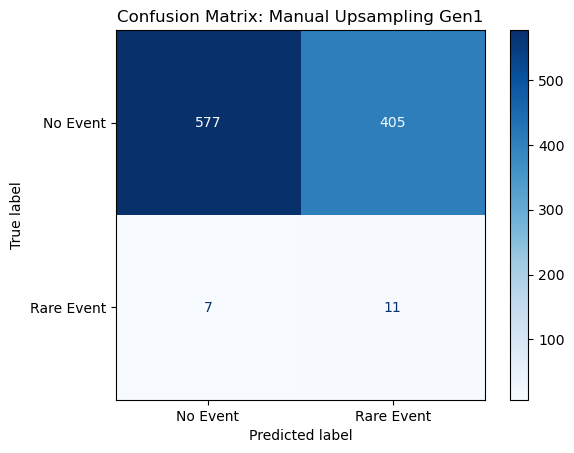


--- Random Undersample Gen1 ---
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       982
           1       0.02      0.56      0.04        18

    accuracy                           0.53      1000
   macro avg       0.50      0.54      0.37      1000
weighted avg       0.97      0.53      0.68      1000

ROC AUC: 0.606
PR AUC: 0.032


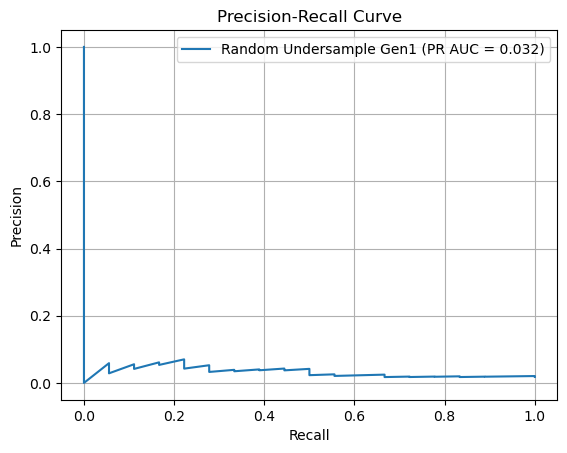

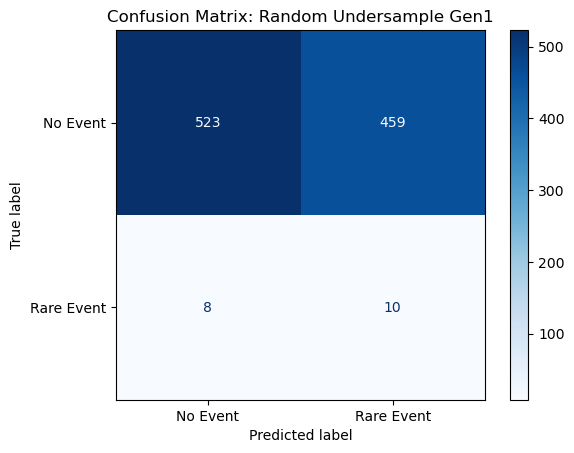


--- Random Undersample Gen1 ---
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       982
           1       0.02      0.56      0.04        18

    accuracy                           0.54      1000
   macro avg       0.50      0.55      0.37      1000
weighted avg       0.97      0.54      0.68      1000

ROC AUC: 0.606
PR AUC: 0.032


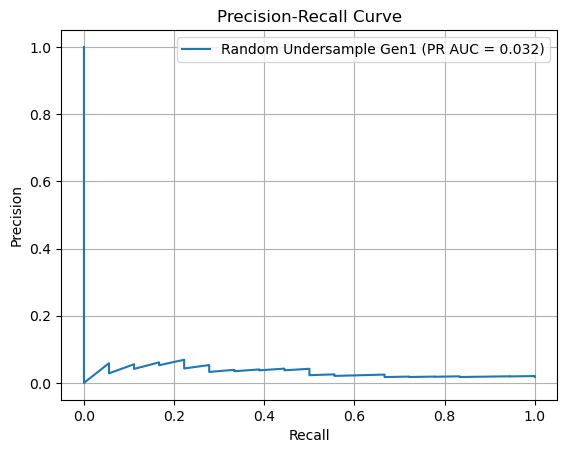

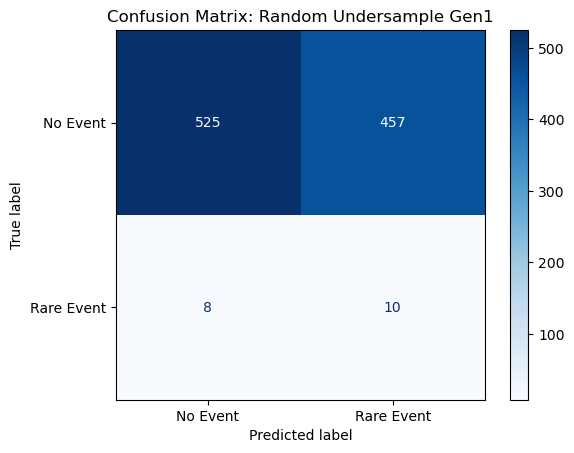


Generation 2

--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.039


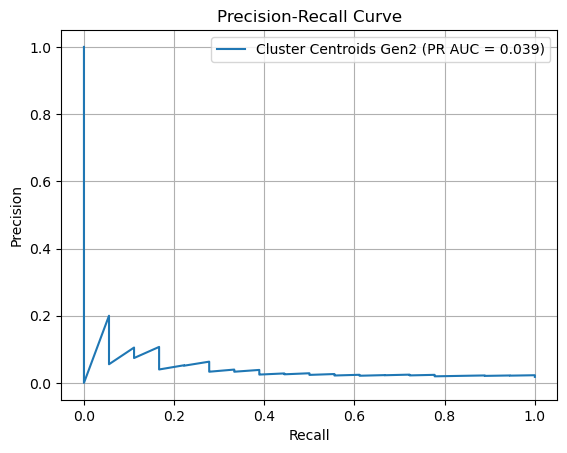

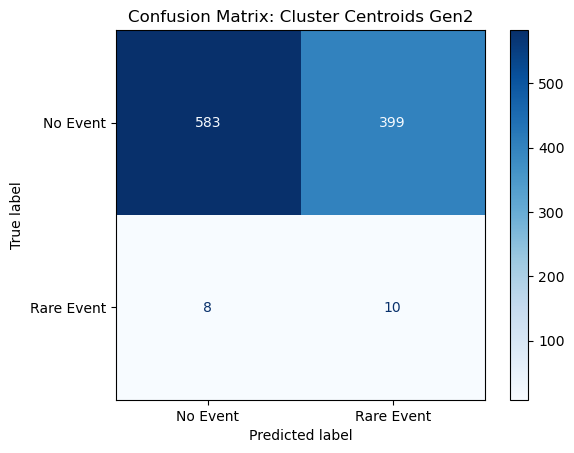


--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.042


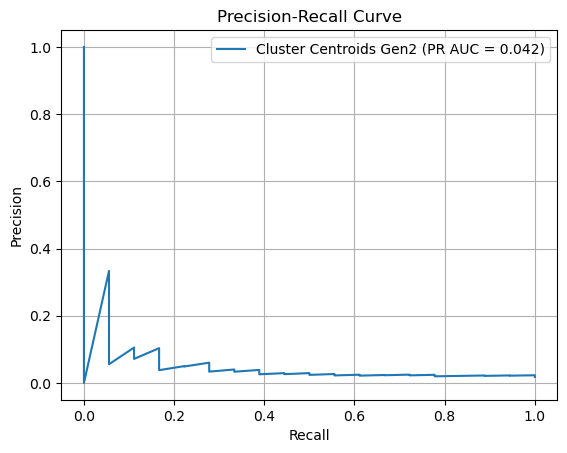

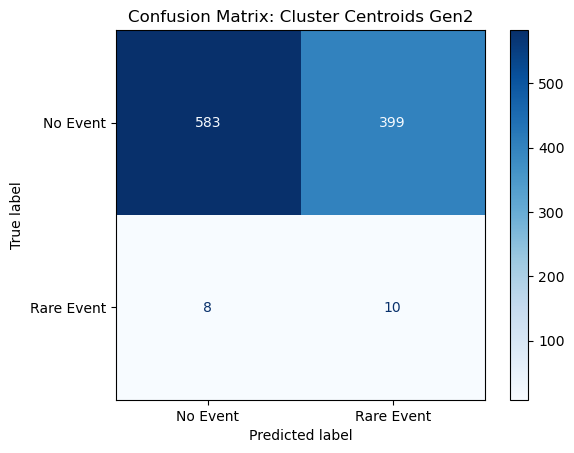


--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


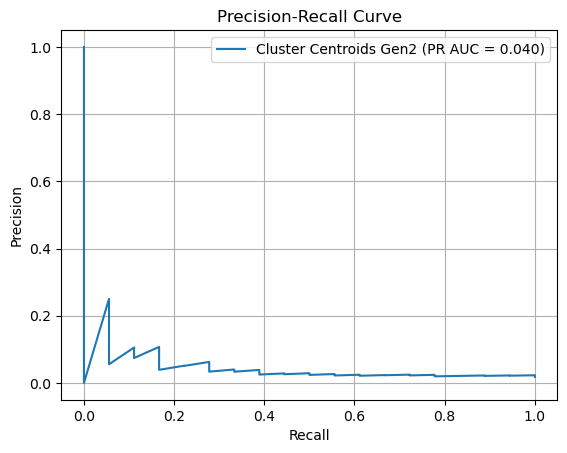

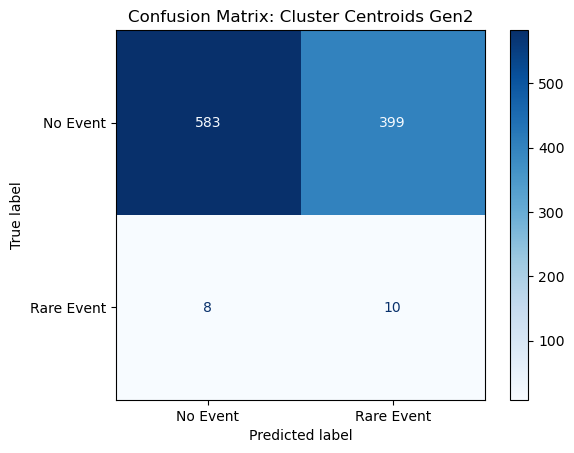


--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.64
PR AUC: 0.042


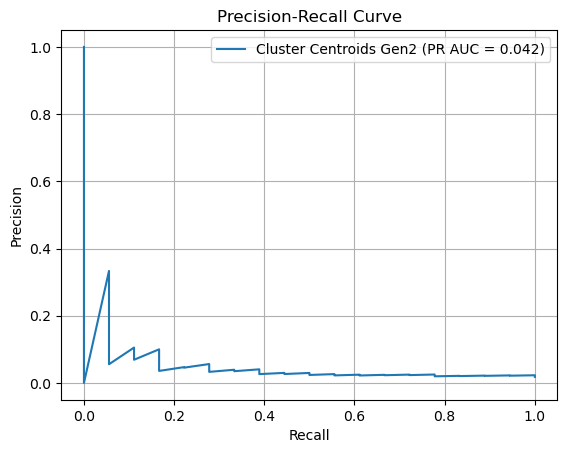

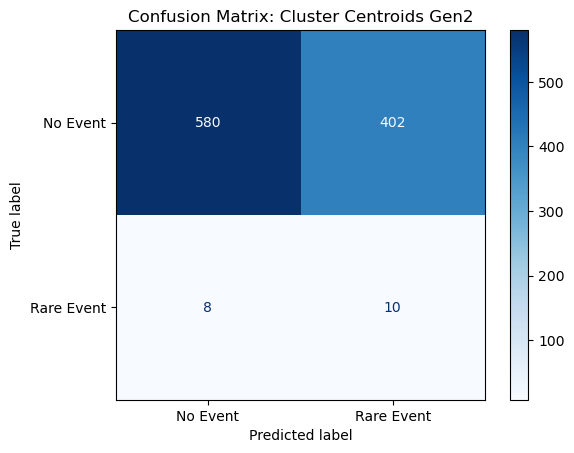


--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


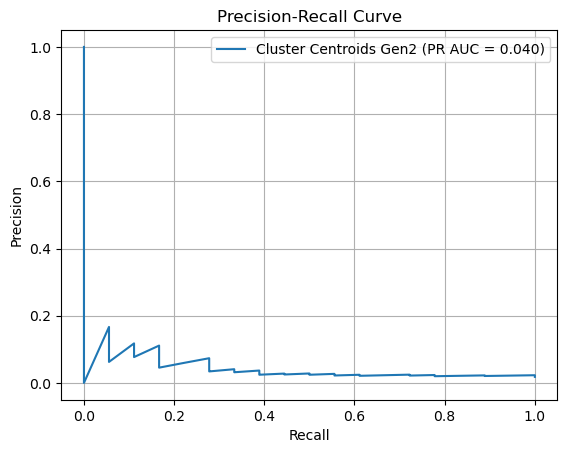

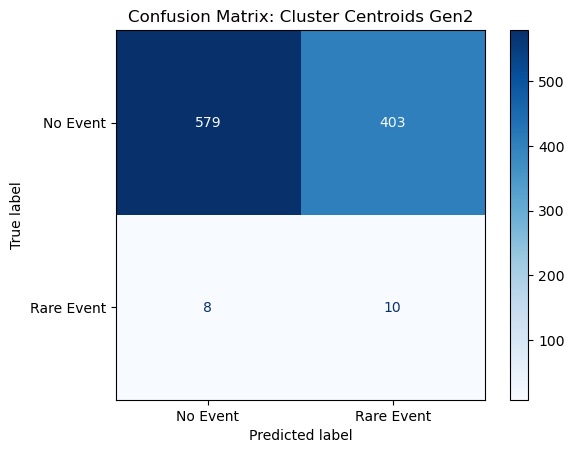


--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.043


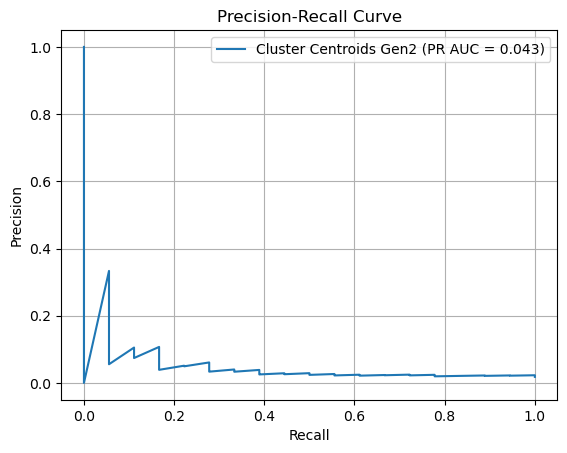

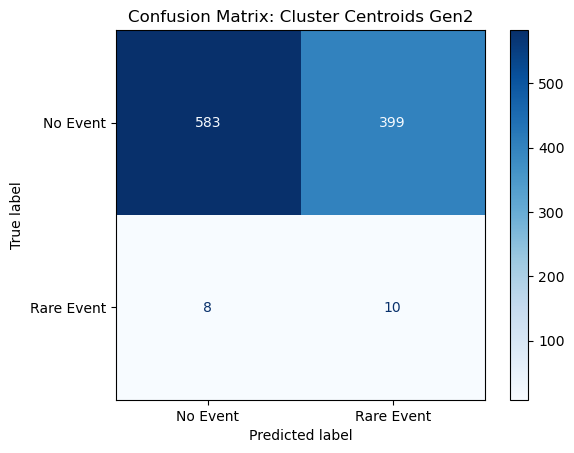


Generation 3

--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.043


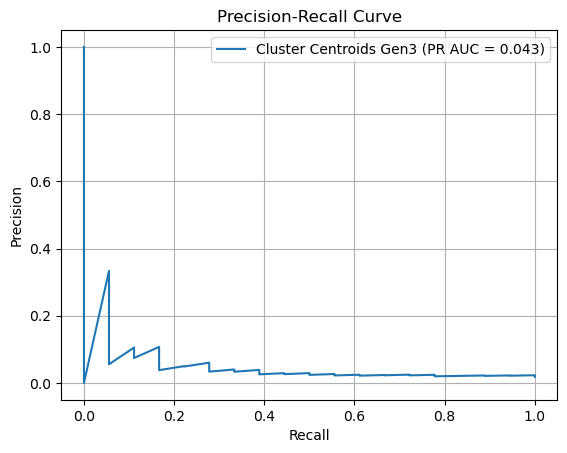

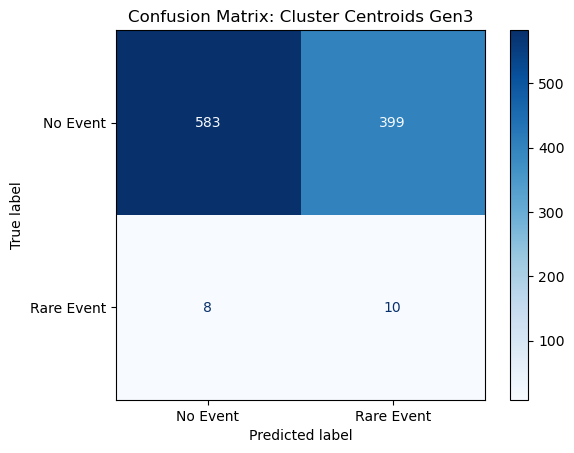


--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


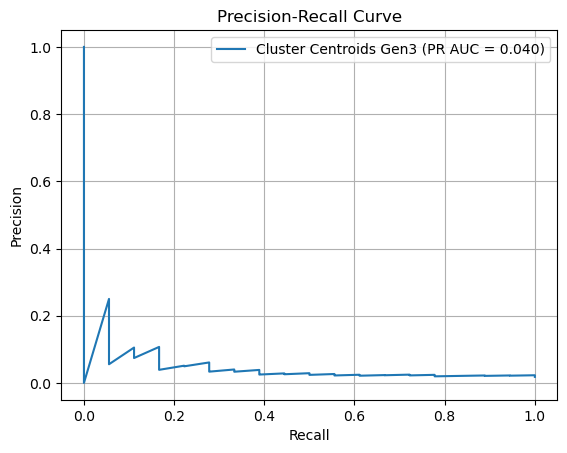

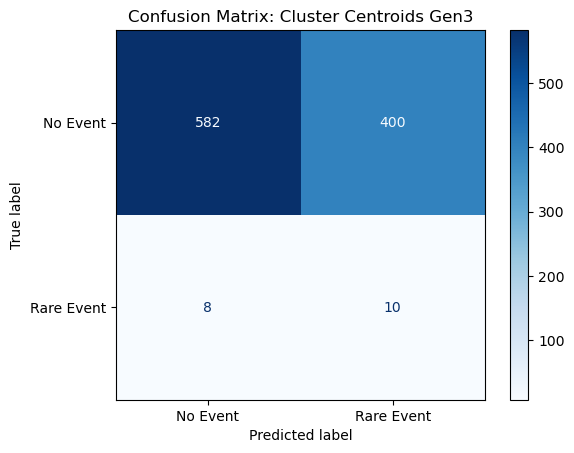


--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.043


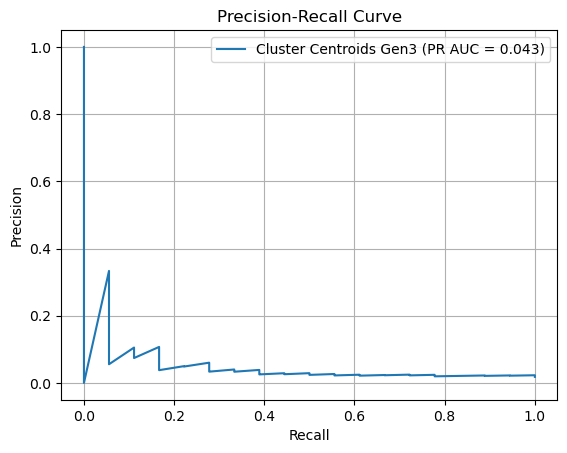

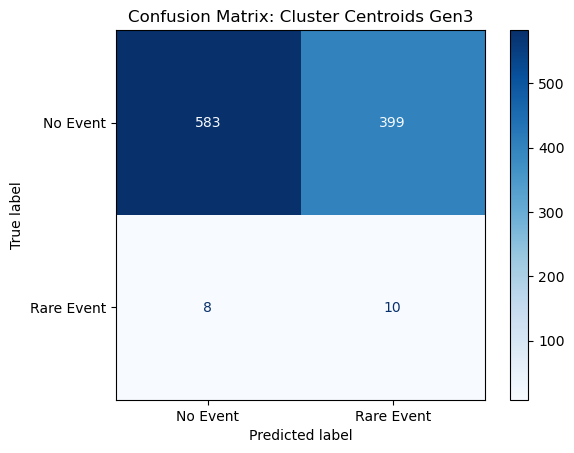


--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.043


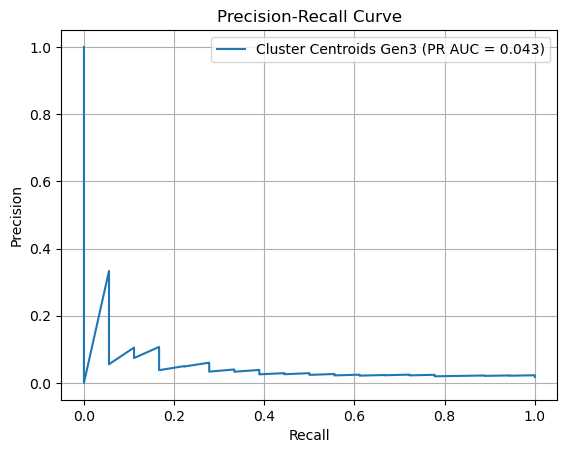

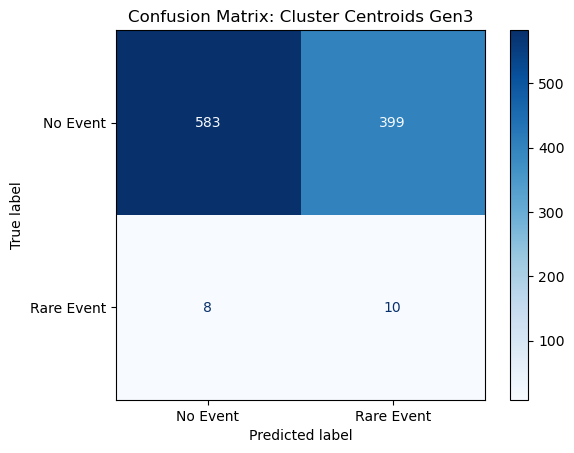


--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.039


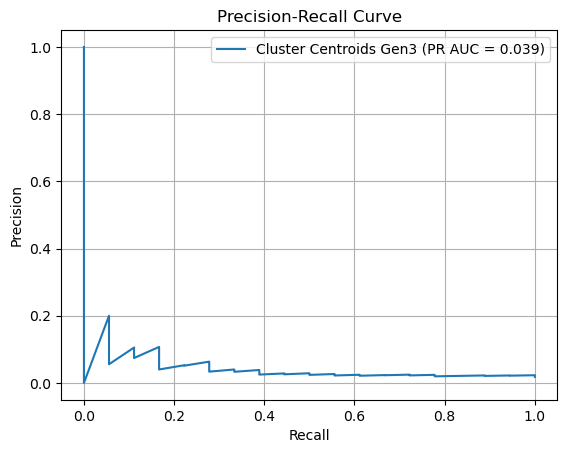

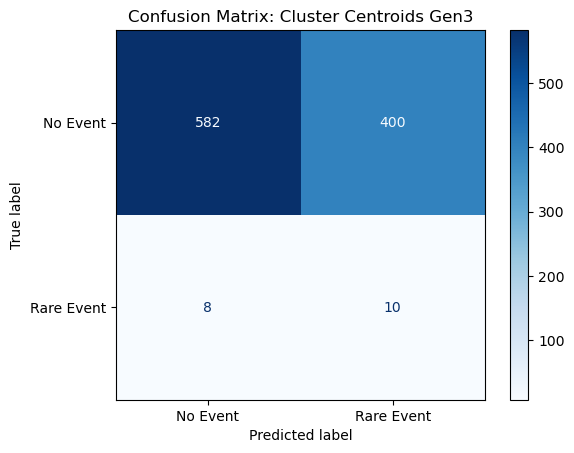


--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.039


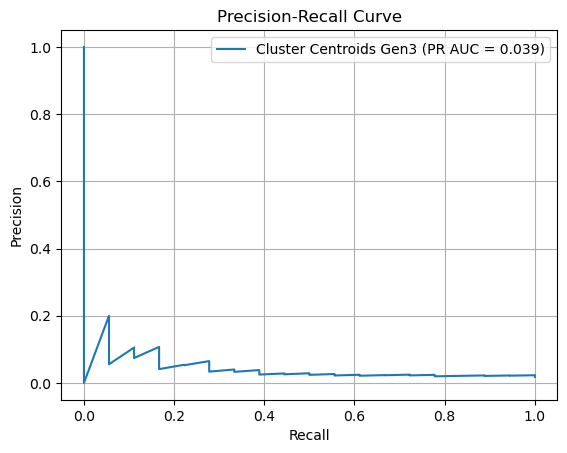

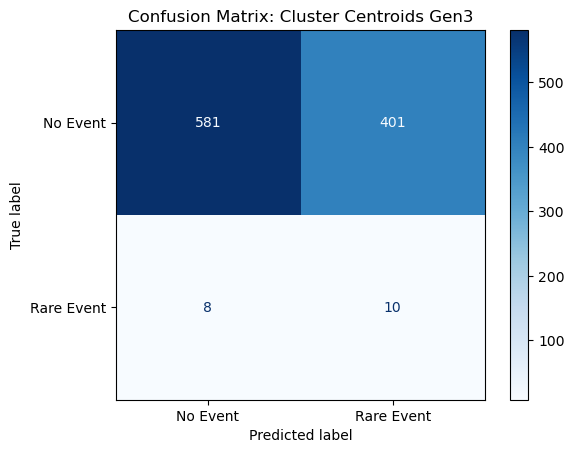

In [62]:
population = breed_and_battle(
    resampled_datasets=resampled_datasets,
    X_test=X_test,
    y_test=y_test,
    generations=3,
    top_k=3
)

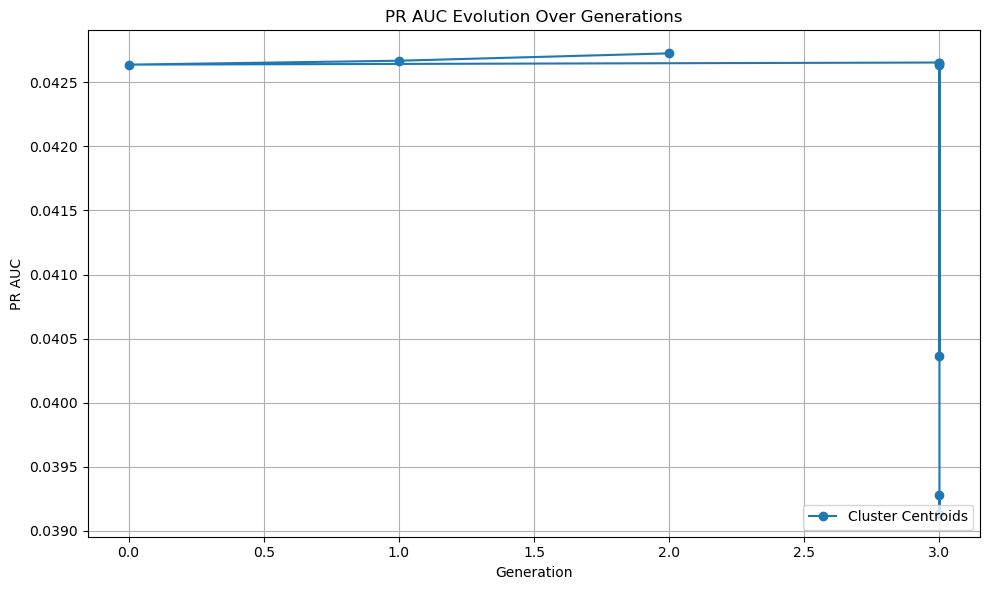

In [63]:
# Track PR AUC per generation per strategy
tracking_df = pd.DataFrame([
    {
        "Generation": model["generation"],
        "Strategy": model["label"],
        "PR AUC": model["score"]["pr_auc"],
        "ROC AUC": model["score"]["roc_auc"],
        "C": model["params"]["C"],
        "l1_ratio": model["params"]["l1_ratio"]
    }
    for model in population
])

# Line plot of PR AUC over generations
plt.figure(figsize=(10, 6))
for label in tracking_df["Strategy"].unique():
    subset = tracking_df[tracking_df["Strategy"] == label]
    plt.plot(subset["Generation"], subset["PR AUC"], marker='o', label=label)

plt.title("PR AUC Evolution Over Generations")
plt.xlabel("Generation")
plt.ylabel("PR AUC")
plt.grid(True)
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0))
plt.tight_layout()
plt.show()

,Strategy,Generation,PR AUC,ROC AUC,C,l1_ratio
0,Cluster Centroids,2,0.042727,0.638493,1.058295,0.538081


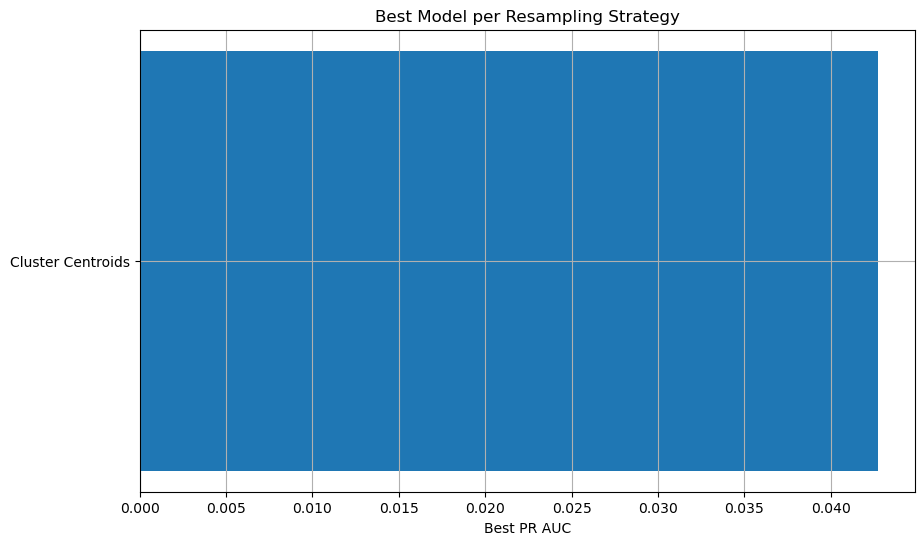

In [66]:
# Best model per strategy
best_by_strategy = tracking_df.sort_values(by="PR AUC", ascending=False).groupby("Strategy").first().reset_index()

# Show as table
display(best_by_strategy[["Strategy", "Generation", "PR AUC", "ROC AUC", "C", "l1_ratio"]])

# Optional bar plot
plt.figure(figsize=(10, 6))
plt.barh(best_by_strategy["Strategy"], best_by_strategy["PR AUC"])
plt.xlabel("Best PR AUC")
plt.title("Best Model per Resampling Strategy")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


--- Ensemble ---
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       982
           1       0.02      0.56      0.04        18

    accuracy                           0.53      1000
   macro avg       0.50      0.54      0.36      1000
weighted avg       0.97      0.53      0.67      1000

ROC AUC: 0.577
PR AUC: 0.023


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


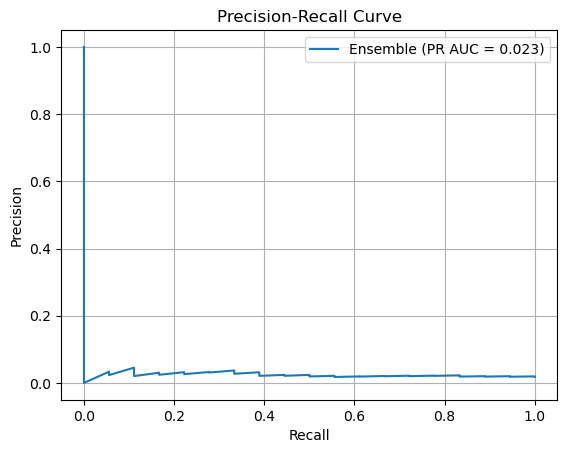

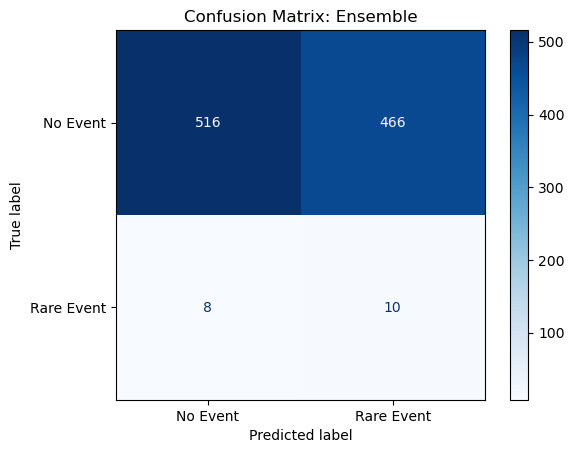

In [67]:
from sklearn.ensemble import VotingClassifier

# Grab top model from each strategy
ensemble_models = [
    (row["Strategy"], population[i]["model"])
    for i, row in best_by_strategy.iterrows()
]

# Create soft voting ensemble
ensemble = VotingClassifier(ensemble_models, voting='soft')
ensemble.fit(X_train, y_train)

# Evaluate ensemble
ensemble_score = evaluate_model(ensemble, X_test, y_test, label="Ensemble")

,Label,C,l1_ratio,ROC AUC,PR AUC
0,Cluster Centroids,1.058295,0.538081,0.638493,0.042727
1,Cluster Centroids,1.074698,0.544907,0.638436,0.042669
3,Cluster Centroids,1.047900,0.516231,0.638663,0.042655
6,Cluster Centroids,1.005527,0.498895,0.638663,0.042651
2,Cluster Centroids,1.000000,0.500000,0.638549,0.042639
5,Cluster Centroids,1.001147,0.506561,0.638380,0.042632
4,Cluster Centroids,1.053068,0.560060,0.637531,0.040361
8,Cluster Centroids,1.005366,0.588694,0.637927,0.039278
7,Cluster Centroids,0.904716,0.518394,0.637701,0.039133


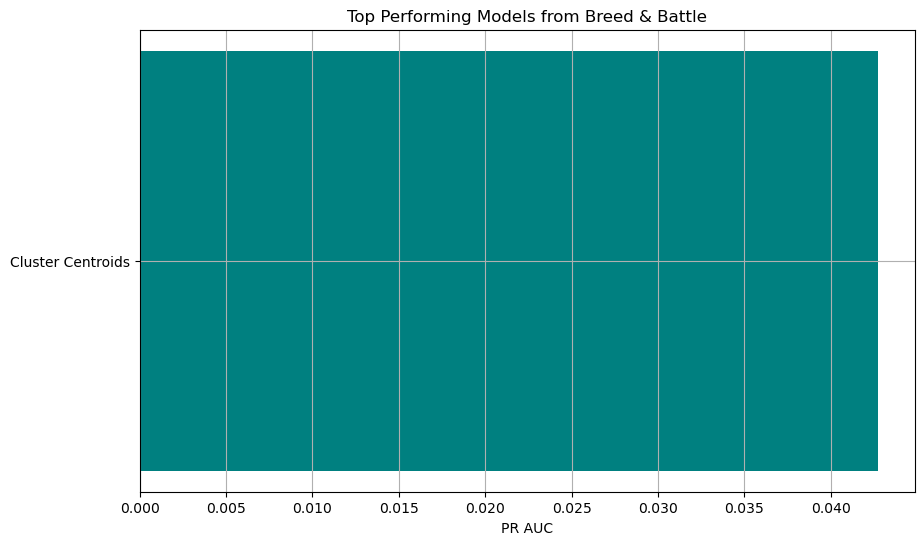

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# 📊 Compile results
final_results = pd.DataFrame([
    {
        "Label": model_info["label"],
        "C": model_info["params"]["C"],
        "l1_ratio": model_info["params"]["l1_ratio"],
        "ROC AUC": model_info["score"]["roc_auc"],
        "PR AUC": model_info["score"]["pr_auc"]
    }
    for model_info in population
]).sort_values(by="PR AUC", ascending=False)

# 🖼️ Display results
display(final_results)

# 📈 Optional: Bar plot of PR AUC
plt.figure(figsize=(10, 6))
plt.barh(final_results["Label"], final_results["PR AUC"], color="teal")
plt.xlabel("PR AUC")
plt.title("Top Performing Models from Breed & Battle")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()